In [164]:
import pytket.backends.ibm as ibm
import pytket.routing as route
import pytket.qiskit as pq
import pytket.transform as opts
import pytket.circuit as tc
import pytket.device as device

from qiskit import *
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.providers.jobstatus import JOB_FINAL_STATES
from qiskit.quantum_info import state_fidelity
from qiskit.providers.aer import noise
import qiskit.ignis.verification.tomography as tomo
from qiskit.tools.visualization import plot_histogram

import numpy as np
%matplotlib inline
import pickle
import time
from copy import deepcopy
import collections
import statistics

In [6]:
#IBMQ.save_account("9dc5c937fcedf3575d64912c02715c0ec0e27043cf5f18040b0304cdd16dac2ea042ffecad4b007b245926a694f92a9ebfdc1ede6b381b004a2fe0ed2cf262b1")
#provider = IBMQ.load_account()
backend = ibm.IBMQBackend(backend_name='ibmq_16_melbourne')
dev = backend.device
arc = dev.architecture
sv_sim = qiskit.Aer.get_backend('statevector_simulator')
melbourne = provider.get_backend(name='ibmq_16_melbourne')
sim = provider.get_backend(name='ibmq_qasm_simulator')

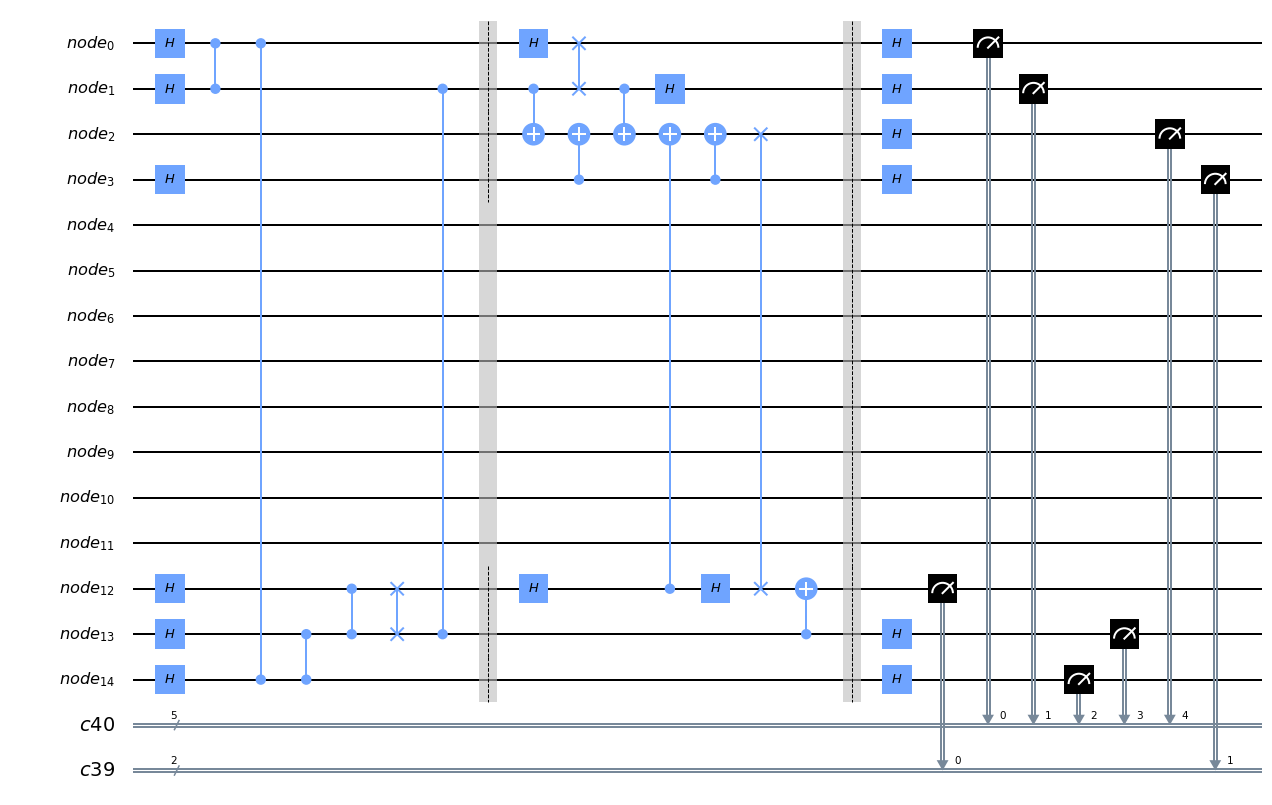

In [190]:
qr = QuantumRegister(7)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr)
qenc = QuantumCircuit(5)

for i in range(5):
    qc.h(i)

for i in range(5):
    if i != 4:
        qc.cz(i,i+1)
    else:
        qc.cz(4,0)
        
for i in range(5):
    qenc.h(i)

for i in range(5):
    if i != 4:
        qenc.cz(i,i+1)
    else:
        qenc.cz(4,0)
        
#Flag qubits in |+>
qc.h(6)
#qc.h(8)
#qc.h(10)
#qc.h(12)
qc.barrier()

#Measurement of ZXIXZ onto S0
qc.cx(0,5)
qc.cx(6,5)
qc.h(1)
qc.cx(1,5)
qc.h(1)
qc.h(3)
qc.cx(3,5)
qc.h(3)
qc.cx(6,5)
qc.cx(4,5)
#qc.barrier()

'''
#Measurement of XIXZZ onto S1
qc.h(0)
qc.cx(0,7)
qc.h(0)
qc.cx(8,7)
qc.h(2)
qc.cx(2,7)
qc.h(2)
qc.cx(3,7)
qc.cx(8,7)
qc.cx(4,7)
qc.barrier()

#Measurement of IXZZX onto S2
qc.cx(10,9)
qc.h(1)
qc.cx(1,9)
qc.h(1)
qc.cx(2,9)
qc.cx(3,9)
qc.cx(10,9)
qc.h(4)
qc.cx(4,9)
qc.h(4)
qc.barrier()

#Measurement of XZZXI onto S3
qc = QuantumCircuit(13)
qc.h(0)
qc.cx(0,11)
qc.h(0)
qc.cx(12,11)
qc.cx(1,11)
qc.cx(2,11)
qc.h(3)
qc.cx(3,11)
qc.h(3)
qc.barrier()
'''

qc_tk = pq.qiskit_to_tk(qc)
qc_tk_opt = route.route(qc_tk, dev)

opt_route = opts.Transform.OptimisePostRouting()
reb_qiskit = opts.Transform.RebaseToQiskit()

#opts.Transform.apply(opt_route, qc_tk_opt)
#opts.Transform.apply(reb_qiskit, qc_tk_opt)

qc_opt = pq.tk_to_qiskit(qc_tk_opt)

qc_tomo = tomo.state_tomography_circuits(qc_opt, [0,1,14,13,2], meas_labels='Pauli', meas_basis='Pauli')
qc_tomo_no_anc = deepcopy(qc_tomo)

for qcirc in qc_tomo:
    qcirc.add_register(cr)
    qcirc.measure(12,cr[0])
    qcirc.h(3)
    qcirc.measure(3,cr[1])
    
qc_tomo[0].draw(output = 'mpl')

In [191]:
# state vector simulation
job_svsim = execute(qenc, backend = sv_sim)
psi = job_svsim.result().get_statevector(qenc)
print(len(psi))

32


In [192]:
#Running on QC
job = execute(qc_tomo, backend = sim, optimization_level = 3, shots = 4096)

start_time = time.time()
job_status = job.status()
while job_status not in JOB_FINAL_STATES:
    print(f'Status @ {time.time() - start_time:0.0f} s: {job_status},'f' ')
    time.sleep(1)
    job_status = job.status()

raw_results = job.result()
new_result = deepcopy(raw_results)

Status @ 0 s: JobStatus.VALIDATING, 
Status @ 1 s: JobStatus.VALIDATING, 
Status @ 3 s: JobStatus.VALIDATING, 
Status @ 4 s: JobStatus.VALIDATING, 
Status @ 5 s: JobStatus.VALIDATING, 
Status @ 6 s: JobStatus.VALIDATING, 
Status @ 8 s: JobStatus.VALIDATING, 
Status @ 9 s: JobStatus.VALIDATING, 
Status @ 10 s: JobStatus.VALIDATING, 
Status @ 12 s: JobStatus.VALIDATING, 
Status @ 13 s: JobStatus.VALIDATING, 
Status @ 14 s: JobStatus.VALIDATING, 
Status @ 16 s: JobStatus.RUNNING, 
Status @ 17 s: JobStatus.RUNNING, 
Status @ 18 s: JobStatus.RUNNING, 
Status @ 20 s: JobStatus.RUNNING, 
Status @ 21 s: JobStatus.RUNNING, 
Status @ 22 s: JobStatus.RUNNING, 
Status @ 23 s: JobStatus.RUNNING, 


In [193]:
flag = []
syndrome = []
for resultidx, _ in enumerate(raw_results.results):
    old_counts = raw_results.get_counts(resultidx)
    new_counts = {}
    
    #change the size of the classical register
    new_result.results[resultidx].header.creg_sizes = [new_result.results[resultidx].header.creg_sizes[0]]
    new_result.results[resultidx].header.clbit_labels = new_result.results[resultidx].header.clbit_labels[0:-2]
    new_result.results[resultidx].header.memory_slots = 5
    
    for reg_key in old_counts:
        reg_bits = reg_key.split(' ')
        flag.append(reg_bits[0][0])
        syndrome.append(reg_bits[0][1])
        new_counts[reg_bits[1]] = old_counts[reg_key]

    new_result.results[resultidx].data.counts = new_result.results[resultidx].data.counts.from_dict(new_counts)

flag = statistics.mode(flag)
syndrome = statistics.mode(syndrome)

tomo_fitter = tomo.StateTomographyFitter(new_result, qc_tomo_no_anc)
rho = tomo_fitter.fit()

# Fidelity
fidelity = state_fidelity(psi, rho)
print('Fit Fidelity =', fidelity)

Fit Fidelity = 0.24967355822686732
